# Atividade complementar (caso 2)
##Cecília De Luca Prioste

Descrição: amostra de sangue de um paciente lactente bebê, sexo masculino, 6 meses. Triagem neonatal alterada evidenciando níveis elevados de fenilalanina e
atraso incipiente no desenvolvimento neuropsicomotor.
Objetivo: identificar variantes genéticas responsáveis pela fenilcetonúria (PKU), fornecendo base para diagnóstico precoce e orientações terapêuticas individualizadas para prevenção de complicações neurológicas.

Identificar e realizar:
- filtragem e limpeza nas variantes
- número de variantes no gene PAH
- frequência alélica da variante
- presença em homozigose ou heterozigose
- doença alelo dominante ou recessivo
- classificação das variantes

In [ ]:
#Instalação dos arquivos direto do drive
!pip install gdown
!gdown --id 1RxiW3cFlgEatVq0T52A54EzzOTNw54jO
!gdown --id 1L5K1zsQF7KfecKr86pR3KWQoePFbw07M
!gdown --id 1Pf3GJQUYEYHK_D4LqMGNdchutzxYjG0M

# 0. Configuração de ambiente padrão


In [ ]:
%%bash
# Instalação do miniconda e mamba
wget --quiet https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh
bash Miniforge3-Linux-x86_64.sh -b -p /usr/local -u
mamba init
mamba config set auto_activate_base true
mamba shell init --shell bash --root-prefix=~/.local/share/mamba
rm Miniforge3-Linux-x86_64.sh

In [ ]:
%%bash
# Instalação de softwares (usados em diferentes etapas ao longo do código)
mamba install -c bioconda -c conda-forge fastqc bwa gatk4 cutadapt samtools bedtools ensembl-vep=115 -y

In [ ]:
%%bash
# Teste de instalação do vep
vep --help

In [ ]:
%%bash
# Criação das pastas para organizar os arquivos que serão gerados
mkdir -p raw fastqc cutadapt bwa gatk vep reference

In [ ]:
%%bash
# Mover arquivos para as suas respectivas pastas e descompactar fasta.gz
mv *.fastq.gz raw/
gunzip -c Chr12-reference.fasta.gz > reference/Chr12-reference.fasta
rm -rf Chr12-reference.fasta.gz sample_data/

# 1. Controle de Qualidade

In [ ]:
%%bash
# Gerar o relatório da qualidade dos reads de sequenciamento
fastqc -o fastqc/ raw/caso2-sindrome-metabolica_R1.fastq.gz raw/caso2-sindrome-metabolica_R2.fastq.gz

In [ ]:
%%bash
# Filtrar sequências muito pequenas e cortar as pontas: etapa para limpeza das reads
cutadapt \
  -u 5 -U 5 \
  -u -5 -U -5 \
  -m 90 \
  -o cutadapt/caso2-sindrome-metabolica-trimmed_R1.fastq.gz \
  -p cutadapt/caso2-sindrome-metabolica-trimmed_R2.fastq.gz \
  raw/caso2-sindrome-metabolica_R1.fastq.gz \
  raw/caso2-sindrome-metabolica_R2.fastq.gz

CUTADAPT: corte de dois pares apenas devido ao tamanho, o que indica boa qualidade do banco de dados adquirido para o caso.

# 2. Mapeamento com a referência do genoma humano

In [ ]:
%%bash
# Genoma humano de referência (Chr12) e remoção de contaminante
samtools faidx reference/Chr12-reference.fasta
bwa index reference/Chr12-reference.fasta

In [ ]:
%%bash
# Processo efetivo de alinhamento com o genoma humano
bwa mem reference/Chr12-reference.fasta \
  -R '@RG\tID:sample1\tSM:sample1\tPL:ILLUMINA\tLB:lib1\tPU:unit1' \
  cutadapt/caso2-sindrome-metabolica-trimmed_R1.fastq.gz \
  cutadapt/caso2-sindrome-metabolica-trimmed_R2.fastq.gz \
  | samtools sort -o bwa/caso2-sindrome-metabolica-mapped-host.bam

In [ ]:
%%bash
# Arquivo bam e bai para visualização do gene PAH no IGV: procurar mutações
samtools index bwa/caso2-sindrome-metabolica-mapped-host.bam

# 3. Chamada de Variantes

In [ ]:
%%bash
# Indexar a referência e BAM para chamada de variantes com GATK
samtools dict reference/Chr12-reference.fasta > reference/Chr12-reference.dict
samtools index bwa/caso2-sindrome-metabolica-mapped-host.bam

In [ ]:
%%bash
# Chamada de variantes
gatk HaplotypeCaller \
  -R reference/Chr12-reference.fasta \
  -I bwa/caso2-sindrome-metabolica-mapped-host.bam \
  -O gatk/caso2-sindrome-metabolica-host-variants.vcf

# 4. Anotação de Variantes

In [ ]:
%%bash
# Baixar o genoma humano
vep_install -a cf -s homo_sapiens -y GRCh38 --NO_UPDATE

In [ ]:
%%bash
# Gerando VCF
bgzip gatk/caso2-sindrome-metabolica-host-variants.vcf
tabix -p vcf gatk/caso2-sindrome-metabolica-host-variants.vcf.gz


In [ ]:
%%bash
# Gerando VCF
bgzip gatk/caso2-sindrome-metabolica-host-variants.vcf
tabix -p vcf gatk/caso2-sindrome-metabolica-host-variants.vcf.gz

In [ ]:
%%bash
# Anotação de variantes a nível de proteína
vep -i gatk/caso2-sindrome-metabolica-host-variants.vcf.gz \
    --output_file vep/caso2-sindrome-metabolica-host-variants.vep.tsv \
    --tab --force_overwrite \
    --offline --cache --dir_cache ~/.vep \
    --assembly GRCh38 \
    --symbol --hgvs --canonical --af_1kg --max_af \
    --everything --pick\
    --stats_file vep/caso2-sindrome-metabolica-host-variants.vep.html


In [ ]:
%%bash
# Anotação de variantes a nível de proteína
vep -i gatk/caso2-sindrome-metabolica-host-variants.vcf.gz \
    --output_file vep/caso2-sindrome-metabolica-host-variants.vep.tsv \
    --tab --force_overwrite \
    --offline --cache --dir_cache ~/.vep \
    --assembly GRCh38 \
    --symbol --hgvs --canonical --af_1kg --max_af \
    --everything --pick \
    --stats_file vep/caso2-sindrome-metabolica-host-variants.vep.html


#5. Interpretação dos resultados

##Relatórios de qualidade FASTQC:

A análise do .html da etapa de controle de qualidade do pipeline indicou boa qualidade da leitura de sequenciamento do paciente. Houve 3 milhões de reads com sequências de 99 a 200 bases. Tanto  R1 quanto R2, foram bastante compatíveis. O %GC (41%) está dentro da faixa esperada para o genoma humano. A cobertura de 450 milhões de bases indica boa qualidade para dar sequência às análises genéticas. Por comportamento da máquina de sequenciamento, as últimas leituras apresentaram má qualidade, possível de analisar no primeiro gráfico gerado (per base sequence quality). Por isso, ao decorrer do código elas foram cortadas (etapa de trim). Não houve reads cortados por má qualidade, um indicativo positivo da leitura, mas que deve ser visto com cautela. É possível que haja reads ruins que não foram cortadas por nível de corte pouco crítico. Uma opção para refazer o código com maior qualidade seria aumentar a criticidade da qualidade das reads, pois a remoção de algumas pode indicar eficiência na limpeza dos dados.

##IGV:
O arquivo .bam gerado ao longo do código foi visualizado no IGV. Nele é possível percorrer, dentro do alinhamento do cromossomo 12, as bases do gene PAH sequenciadas em comparação com o gene humano de referência. Foram identificadas 4 mutações no gene PAH, duas presentes em éxons. Integrando as informações de localização fornecidas pelo arquivo .tsv (interpretado adiante), identificou-se a região exata das duas bases mutadas nas regiões codificantes (exon).

BASE 1: localização 102852923
(IMAGEM 1)
presente em uma região codificante, uma base A (genoma referência) teve vários missmatches com uma base G da leitura.  

BASE 2: localização 102866775
(IMAGEM 2)
houve missmatches, mas em uma região não codificante do gene, então a análise de mutação dela não foi detalhada e levada pra frente nessa análise.

BASE 3: localização 102894918
(IMAGEM 3)
presente em uma região codificante, uma base C (genoma referência) teve vários missmatches com uma base T da leitura.

BASE 4: não foi documentada no arquivo .tsv, mas é possível de ser observada no IGV. Entretanto, também está presente em um intron, então não foi levada a frente.

##TSV:

É possível observar três linhas correspondentes à mutações no gene PAH (149, 150 e 151). A do meio corresponde a não codificante, classificada como intron_variant.

**LINHA 149: NC_000012.12_102852923_A/G**

alelo variante: G

consequência: missense_variant

impacto: moderado

predição de impacto na codificação proteica: provavelmente danosa (1)

número de exons: 7/13

significância clínica da variante: patogênica



**LINHA 151: NC_000012.12_102894918_C/T**

alelo variante: T

consequência: missense variant, slplice_region_variant

impacto: moderado

predição de impacto na codificação proteica: benigna (0,003)

número de exons: 3/13

significância clínica da variante: classificação incerta (vouss)


##VEP:
O VEP foi utilizado para conferir as informações fornecidas pela análise do TSV e do IGV a respeito do cromossomo 12. Ele indicou a contagem de 74 variantes no cromossomo, com consequências variáveis (IMAGEM 4). Ele indicou 4 missense_variant, o que corresponde com a interpretação no IGV. A maioria das variantes é em introns, o que é bom para o paciente.

No SIFT summary é possível observar que há uma variante deleterious_low_confidence, correspondente à da linha 149 do TSV. Ela indica que a mutação pode afetar negativamente a função da proteína, o que é condizente com a sua classificação patogênica. Além disso, há duas variantes toleratedes, uma delas correspondente à da linha 151, que diz que ela não deve impactar na função proteica. A outra tolerated e a tolerated_low_confidence correspondem às encontradas nos introns no IGV, o que faz sentido para dizer que não afetem a proteína (IMAGEM 5).

O polyphen summary reforça a ideia de que há uma mutação que provavelmente altera a estrutura ou função da proteína (IMAGEM 6).

##VCF:

O VCF gerado foi utilizado para analisar os pares de alelos nas variantes, a fim de identificar se elas estavam em homozigose ou heterozigose. A localização correspondente das duas mutações está nas linhas 69 e 71 do .vcf.
Nelas, é possível identificar que ambas tem frequência alélica (AF) de 0,5, o que as classifica como variantes heterozigóticas (IMAGEM 7). Isso significa que a mutação é de alelo dominante, já que ela está sendo expressa mesmo em heterozigose.

#6 . Imagens

### IMAGEM 1: gene 1 no IGV


---



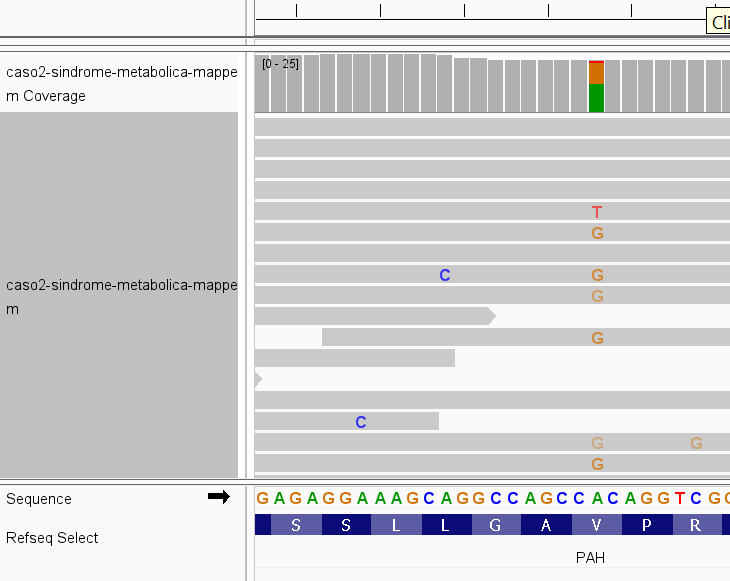

### IMAGEM 2: gene 2 no IGV


---



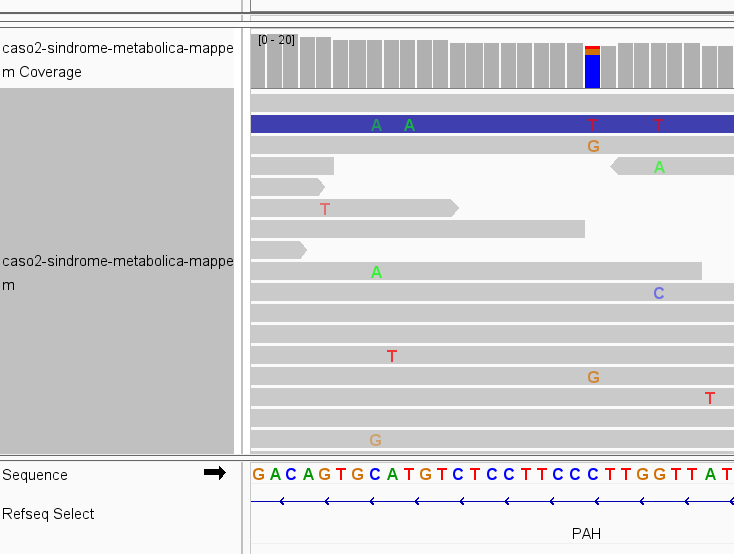

###IMAGEM 3: gene 3 no IGV


---



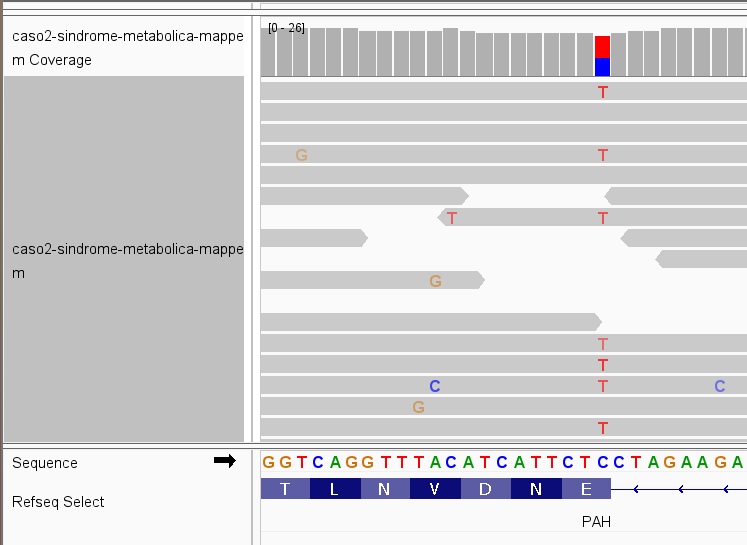

###IMAGEM 4: consequência das variantes (VEP)


---

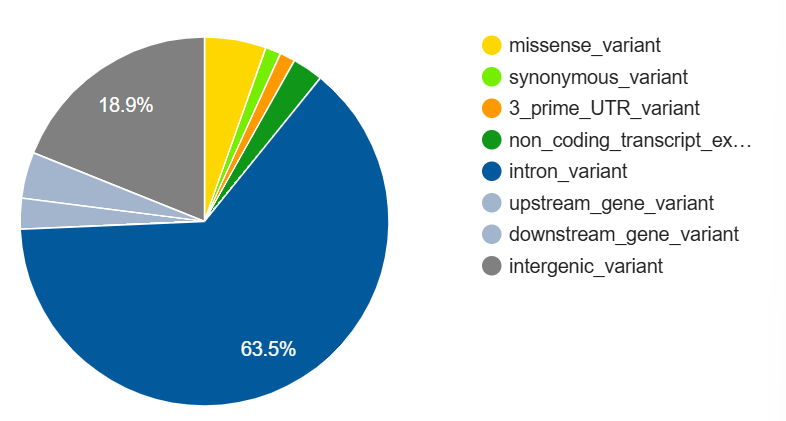

### IMAGEM 5:SIFT summary das mutações no cromossomo 12


---


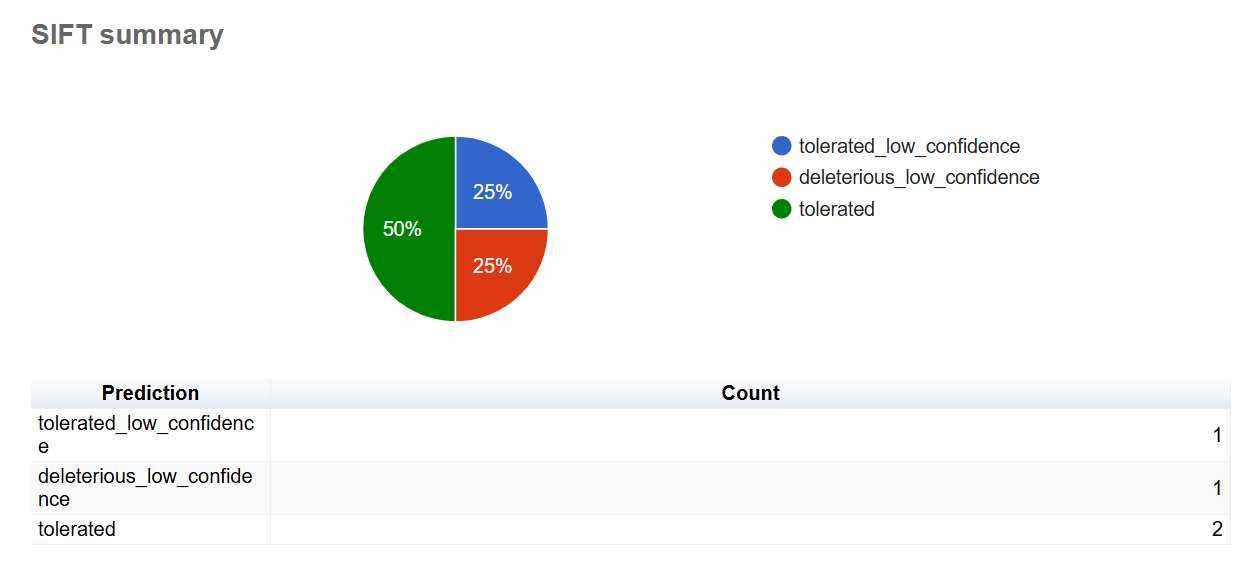

### IMAGEM 6: Polyphen summary das mutações do cromossomo 12


---

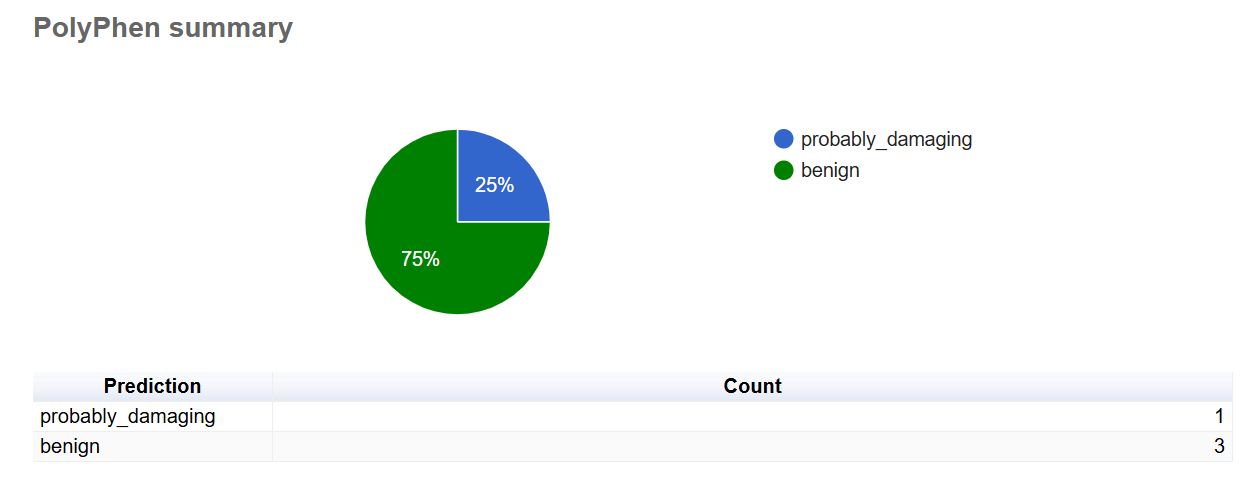

### IMAGEM 7: VCF das bases mutadas


---



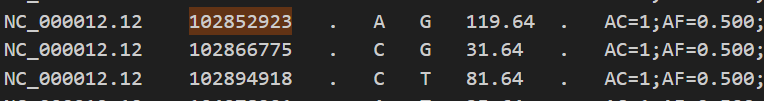

# 7. Conclusão

Os resultados integrados indicam que a qualidade do sequenciamento foi adequada para a detecção de variantes. O gene PAH apresenta duas mutações heterozigóticas nas regiões codificantes. Uma delas (localização 102852923) mostra potencial patogênico, podendo impactar a função da fenilalanina-hidroxilase. A outra (localização 102894918) apresenta características benignas, mas teve classificação incerta (VUS), então é indicado a repetição da análise para ela.

É possível correlacionar a mutação nesse gene com artigos no PubMed (indicados no arquivo TSV) que estudam essa disfunção na proteína relacionada ao quadro clínico de fenilcetonúria. Essa análise é compatível com os sintomas do paciente, a elevação da fenilalanina e atraso no desenvolvimento neuropsicomotor.

# 8. Laudo

Nome: ...

Sexo: masculino

Idade: 6 meses

Material de análise: amostra de sangue

Indicação clínica: triagem neonatal alterada com níveis elevados de fenilalanina e atraso no desenvolvimento psciomotor


### objetivo
  O pipeline teve como objetivo identificar variantes genéticas no gene PAH, responsáveis pela fenilcetonúria, a fim de confirmar o diagnóstico e orientar condutas médicas.

### metodologia
- Controle de qualidade das leituras
- Alinhamento ao genoma humano de referência CRCh38/hg3
- Detecção de variantes com GATK/FreeBayes
- Identificação e classificação da variante com arquivo TSV
- Anotação funcional com VEP
- Visualização e confirmação manual com IGV

### resultados

1) Variante posição 102852923  
  Variante missense, do tipo substituição de aminoácido. Efeito provavelmente danoso. Predição funcional patogênica, com zigosidade heterozigótica.

2) Variante posição 102894918
  Variante missense, em região de splice, do tipo substituição de aminoácido. Predição funcional incerta (VUS), com efeito benigno. Zigosidade heterozigótica.

### conclusão
  O sequenciamento identificou duas variantes heterozigóticas no gene PAH, sendo uma delas patogênica, associada a fenilcetonúria. O resultado é compatível com o diagnóstico de PKU em heterozigose composta.

### recomendações
  Pode-se realizar confirmação diagnóstica com sequenciamento dos pais.
  Deve-se realizar acompanhamento médico de acordo com as indicações para tratamento da PKU.

Local e data: 31/10/2025

Faculdade Israelita de Ciências da Saúde Albert Einstein

Responsável: Cecília De Luca Prioste